# Differential Kinetics

In systems that represent multiple lineages and processes, genes are likely to show different kinetic regimes acrros subpopulations. Distinct cell states and lineages are typically governed by different variations in the gene regulatory networks and may exhibit different splicing kenetics which give rise to genes that display multiple trajectories in phase space.

The dynamical model can be used to perform a likelihood-ratio test for differential kinetics. This can detect clusters that display kinetic behavior that cannot be well explained by a singel model of the overall dynamics.Clustering cell types into their different kenetic regimes then allows fitting each regime separately.

Apply differential kinetic analysis to dentate gyrus neurogenesis, which comprises multiple heterogeneous subpopulations.

In [25]:
import scvelo as scv
scv.logging.print_version()

Running scvelo 0.3.1 (python 3.11.6) on 2024-01-25 03:53.


ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI no longer supports 'pip search' (or XML-RPC search). Please use https://pypi.org/search (via a browser) instead. See https://warehouse.pypa.io/api-reference/xml-rpc.html#deprecated-methods for more information.


In [26]:
scv.settings.verbosity = 3
scv.settings.presenter_view = True
scv.settings.set_figure_params('scvelo')

## Prepare the Data

Gene selection, log-normalizing, and computing moments

In [27]:
adata = scv.datasets.dentategyrus()

In [28]:
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 11019 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


/home/mesqueda/miniconda3/envs/scanpy/lib/python3.11/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## Basic Velocity Estimation

In [29]:
scv.tl.velocity(adata)
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


/home/mesqueda/miniconda3/envs/scanpy/lib/python3.11/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


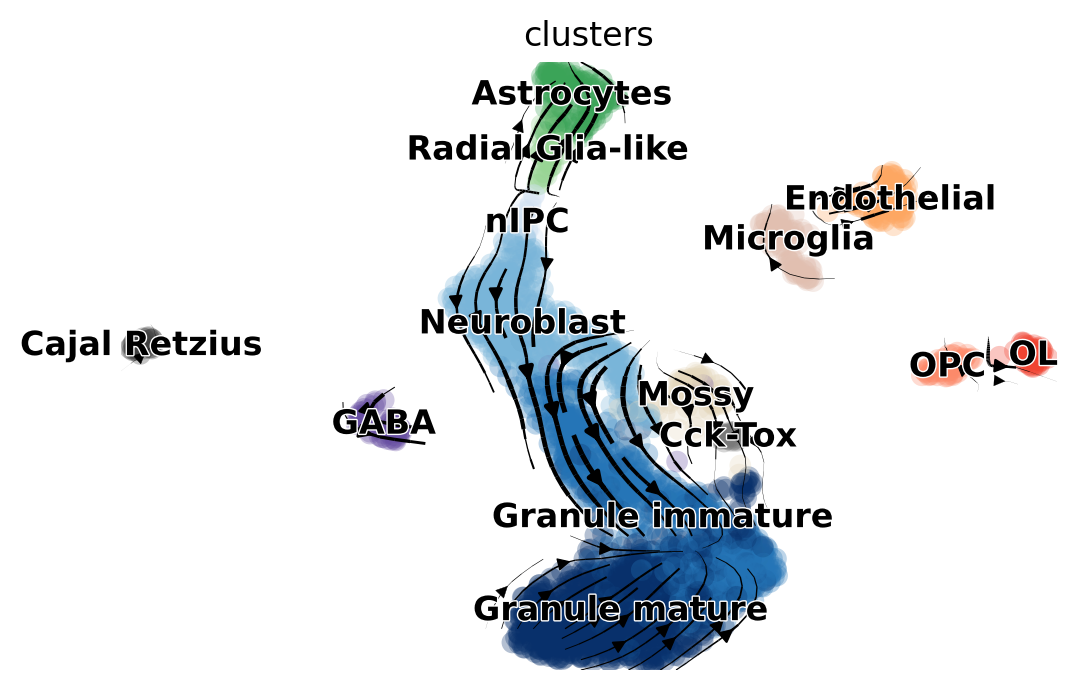

In [30]:
scv.pl.velocity_embedding_stream(adata, basis='umap')

## Differential Kinetic Test

Distinct cell types and lineages may exhibit different kinetics regimes as these can be governed by a different network structure. Even if cell types or lineages are related, kinetics can be differential due to alternative splicing, alternative polyadenylation and modulations in degradation.

The dynamical model allows us to address this issue with a likelihood ratio test for differential kinetics to detect clusters/lineages that display kinetic behavior that cannot be sufficiently explained by a single model for the overall dynamics. Each cell type is tested whether an independent fit yields a significantly improved likelihood.

The likelihood ratio, following an asymptotic chi-squared distribution, can be tested for significance. Note that for efficiency reasons, by default an orthogonal regression is used instead of a full phase trajectory to test whether a cluster is well explained by the overall kinetic or exhibits a different kinetic.

In [31]:
var_names = ['Tmsb10', 'Fam155a', 'Hn1', 'Rpl6']
scv.tl.differential_kinetic_test(adata, var_names=var_names, groupby='clusters')

recovering dynamics (using 1/16 cores)
    finished (0:00:01) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)

outputs model fit of gene: Rpl6
testing for differential kinetics
    finished (0:00:00) --> added 
    'fit_diff_kinetics', clusters displaying differential kinetics (adata.var)
    'fit_pvals_kinetics', p-values of differential kinetics (adata.var)

outputs model fit of gene: Rpl6


In [32]:
scv.get_df(adata[:, var_names], ['fit_diff_kinetics', 'fit_pval_kinetics'], precision=2)

,fit_diff_kinetics,fit_pval_kinetics
index,,
Tmsb10,Endothelial,6.02e-16
Fam155a,Cajal Retzius,8.35e-161
Hn1,Microglia,3.02e-03
Rpl6,Microglia,5.69e-16


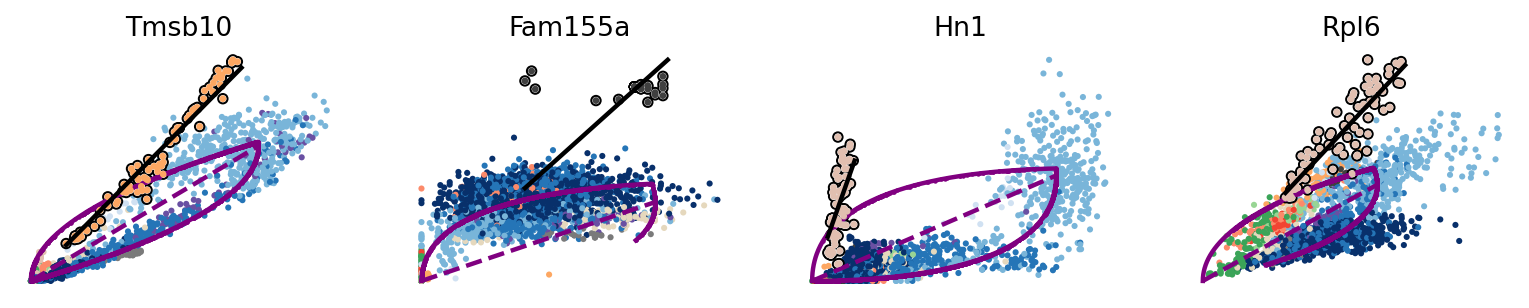

In [33]:
kwargs = dict(linewidth=2, add_linfit=True, frameon=False)
scv.pl.scatter(adata, basis=var_names, add_outline='fit_diff_kinetics', **kwargs)

In *Tmsb10*, Endothelial display a kinetic behavior (outlined, with the black line fitted through), that cannot be well explained by the overall dynamics (purple curve).

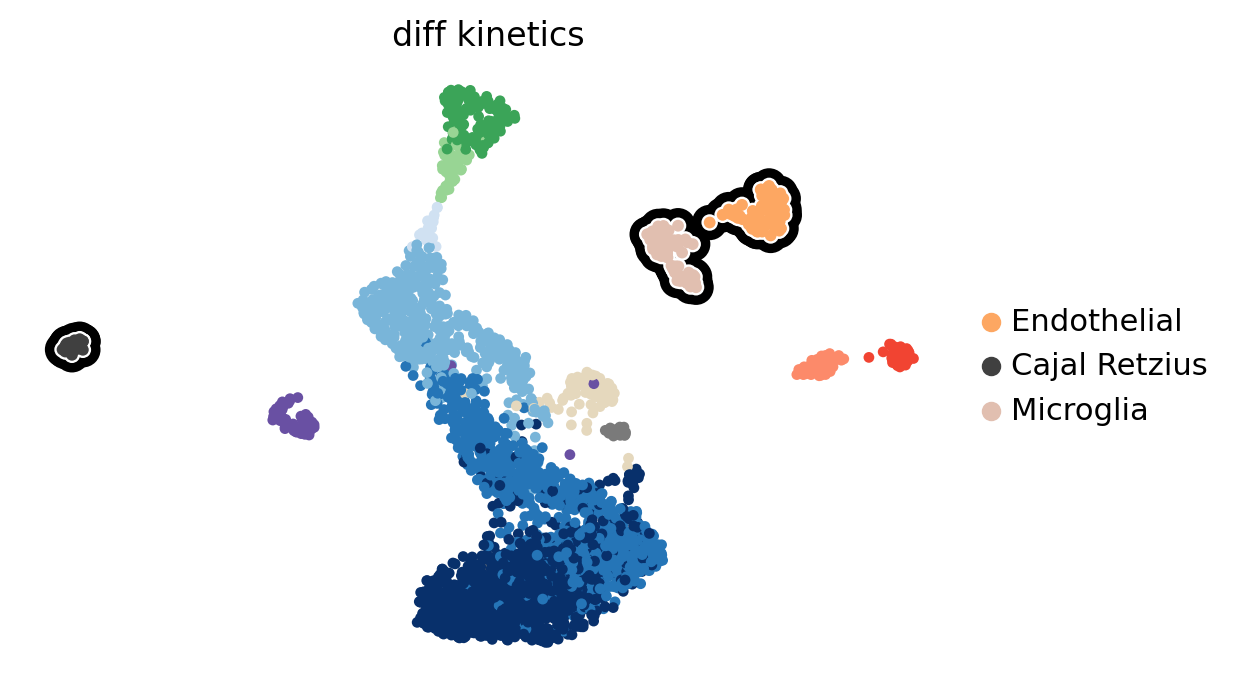

In [34]:
diff_clusters = list(adata[:, var_names].var['fit_diff_kinetics'])
scv.pl.scatter(adata, legend_loc='right', size=60, title='diff kinetics',
              add_outline=diff_clusters,outline_width=(.8, .2))

## Testing top-likelihood genes

Screening through the top-likelihood genes, find some gene-wise dynamics that display multiple kinetic regimes.

In [35]:
scv.tl.recover_dynamics(adata)

# adata.write('data/pancreas.h5ad', compression='gzip')
# adata = scv.read('data/pancreas.h5ad')

recovering dynamics (using 1/16 cores)


  0%|          | 0/519 [00:00<?, ?gene/s]

    finished (0:02:35) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [36]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index[:100]
scv.tl.differential_kinetic_test(adata, var_names=top_genes, groupby='clusters')

testing for differential kinetics
    finished (0:00:09) --> added 
    'fit_diff_kinetics', clusters displaying differential kinetics (adata.var)
    'fit_pvals_kinetics', p-values of differential kinetics (adata.var)


Cell types that are distinct from the main granule - such as Cck/Tox, GABA, Endothelial, and Microglia - occur frequently.

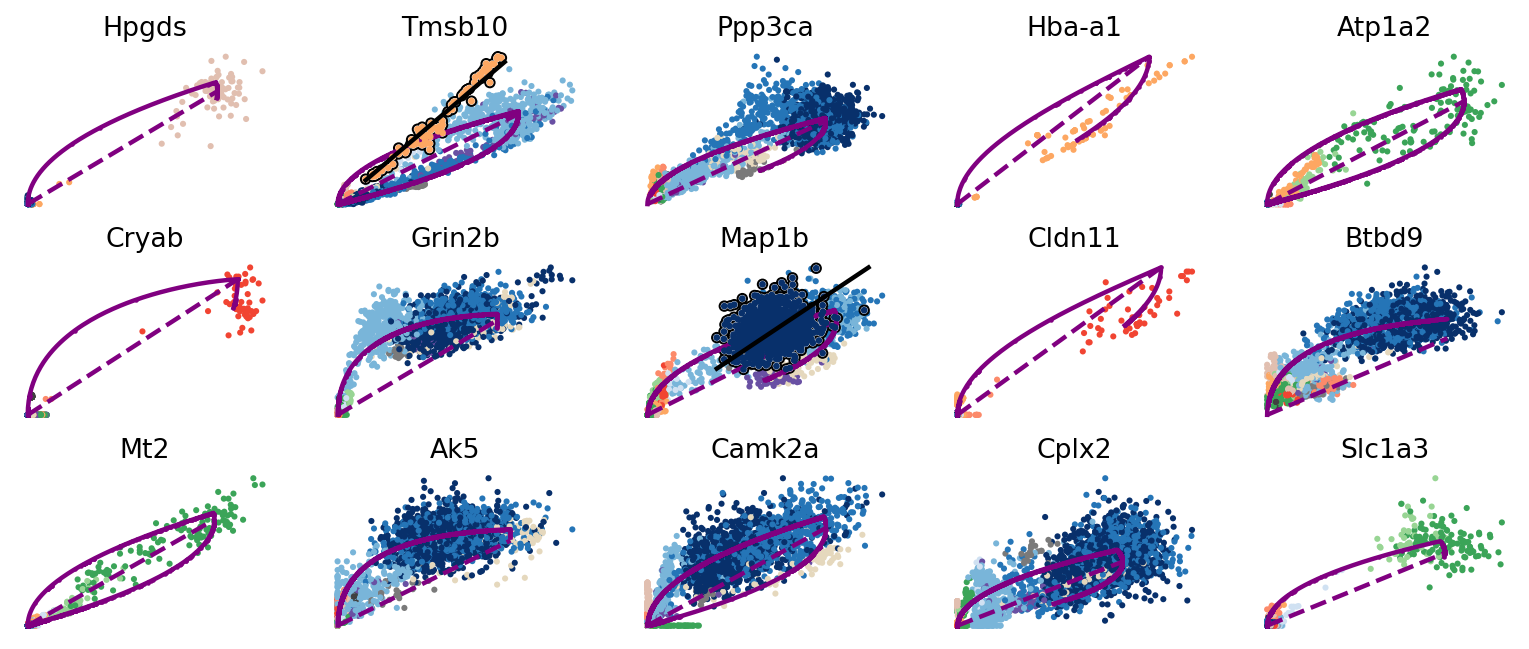

In [37]:
scv.pl.scatter(adata, basis=top_genes[:15], ncols=5, add_outline='fit_diff_kinetics', **kwargs)

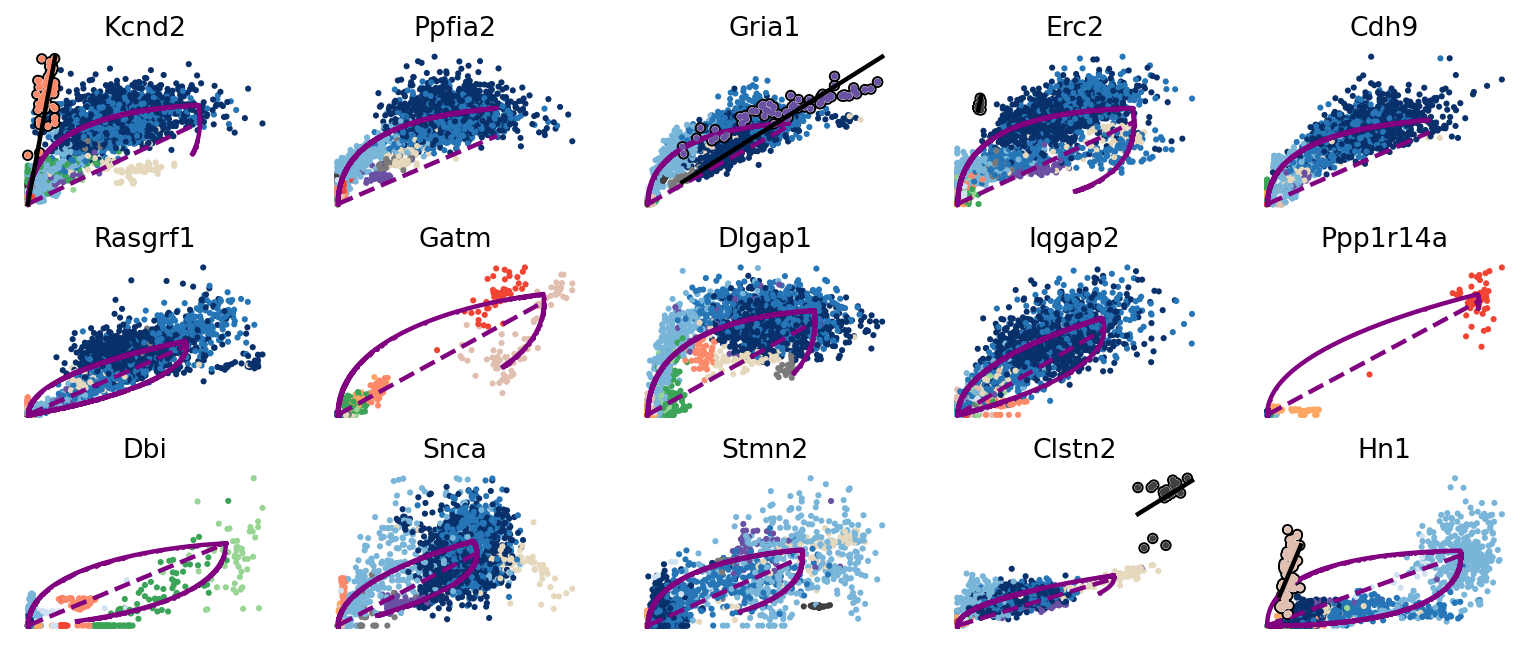

In [38]:
scv.pl.scatter(adata, basis=top_genes[15:30], ncols=5, add_outline='fit_diff_kinetics', **kwargs)

## Recompute velocities

Velocities can be recomputed leveraging the information of multiple competing kinetic regimes.

In [39]:
scv.tl.velocity(adata, diff_kinetics=True)
scv.tl.velocity_graph(adata)

computing velocities


/home/mesqueda/miniconda3/envs/scanpy/lib/python3.11/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


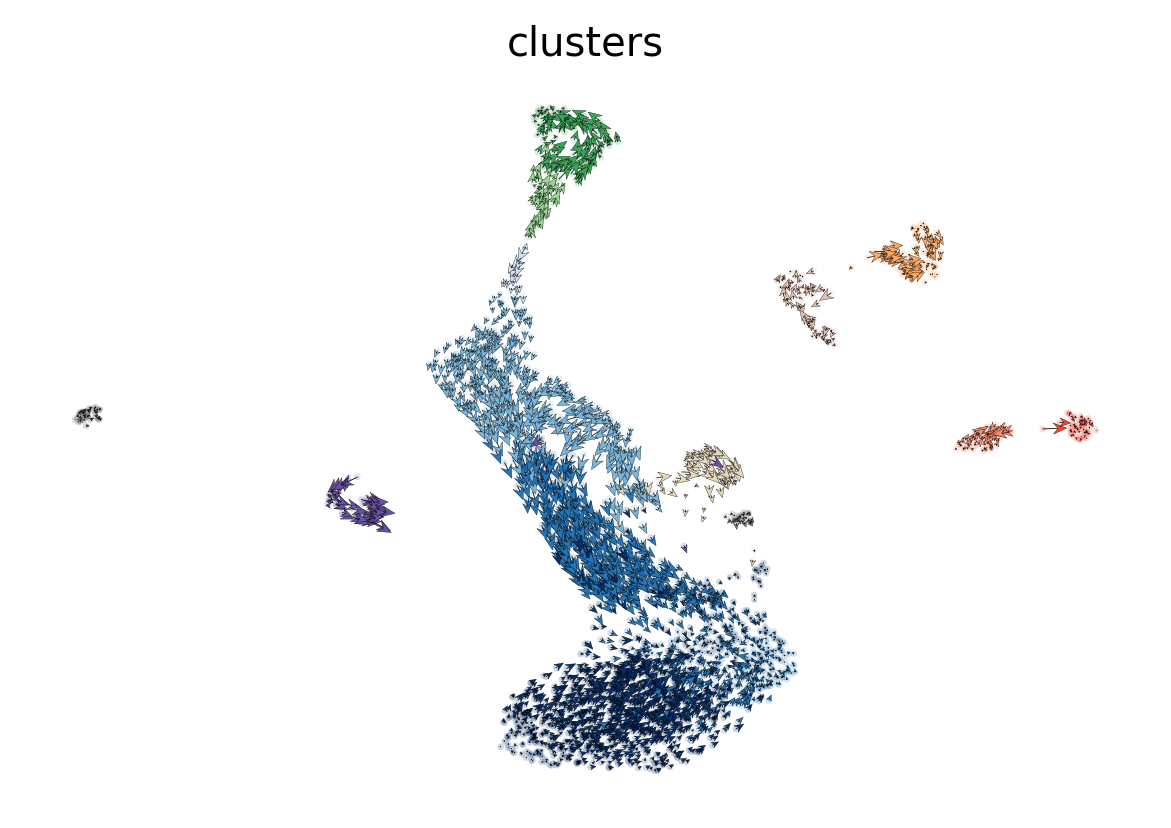

In [40]:
scv.pl.velocity_embedding(adata, dpi=120, arrow_size=2, arrow_length=2)